In [24]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models import AdjointAdvectionDiffusionModel as PDEModel

from advectionGP.wind import WindSimple#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

In [25]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,5) # x locations
yloc=np.linspace(1,9,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [26]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.random.rand(4)*10 # lower time
xloc=np.random.rand(4)*10 # x locations
yloc=np.random.rand(4)*10 # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X2= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X2[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X2[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X2[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X2[:,1] = X2[:,0]+0.1 # upper time

sensorsTest = FixedSensorModel(X2,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [80]:
k_0 = 0.1 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,50,50] # grid size for time, x and y


u1 = 0.01
u2 = 0.01
windmodel=WindSimple(u1,u2) # establish fixed wind model
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

#sourceGT=(m.computeSourceFromPhi(z))# Compute source

sourceGT = np.zeros(m.resolution)
x = np.linspace(0,10,50)
y = np.linspace(0,10,50)
Gco=np.asarray(np.meshgrid(x,y,indexing='ij'))
sourceGT[:,0:50,0:50]=np.exp(-(1/1)*(Gco[0]-5)**2)*np.exp(-(1/1)*(Gco[1]-5)**2)

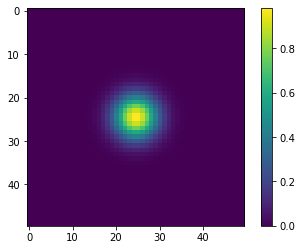

In [81]:
plt.imshow(sourceGT[0])
plt.colorbar()

In [82]:
Gco.shape

(2, 50, 50)

In [83]:
m.sensormodel=sensors
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
concTrain[concTrain<0]=0
m.concentration=concTrain
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [84]:
m.sensormodel=sensorsTest
concTest=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTest= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [122]:
N_feat =2000 #Number of features used to infer the source
k1 = EQ(0.3, 2.0) 
k2 = EQ(0.3, 2.0) 

mInfer = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressInfer = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio

concInfer = mInfer.computeConcentration(sourceInfer)

yOut = mInfer.computeObservations()

Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


In [123]:
np.mean((concInfer-concTrain)**2)

0.21037002818007794

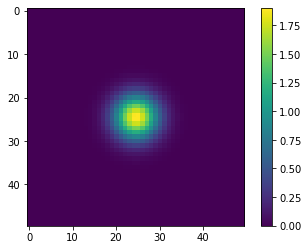

In [126]:
plt.imshow(concTrain[10])
plt.colorbar()

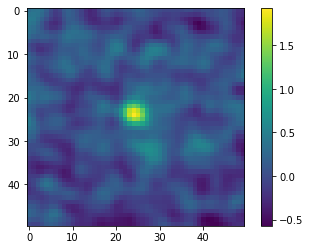

In [127]:
plt.imshow(concInfer[10])
plt.colorbar()

In [128]:
regressInfer = mInfer.computeModelRegressors(compact=True) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ,compact=True) # Generates estimated source using inferred distributio
concInfer = mInfer.computeConcentration(sourceInfer)
yOut = mInfer.computeObservations()

Calculating Adjoints...
249/250 
Calculating Phis...
Computing Source from Phi...
1999/2000 
Computing SS...
Inverting SS...
Computing meanZ
Done
Computing Source from Phi...


In [129]:
np.mean((concInfer-concTrain)**2)

0.3258103193388315

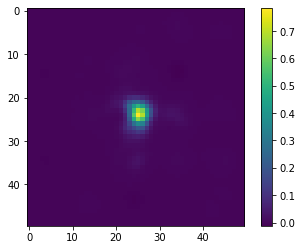

In [130]:
plt.imshow(concInfer[10])
plt.colorbar()

In [106]:
def getPhiCompact(self,mu,coordList):
        """
        Generates a (N_feat,Nt,Nx,Ny) matrix of basis vectors using features from generateFeatures 
        Arguments:
            coords: map of all (t,x,y) points in the grid
        """
        for mus in mu:
            phi=(1/np.sqrt(2*self.sigma2*np.pi))*np.exp(-(1/(2*self.l2[0]**2))*(2*(mus[0]-np.array(coordList[0]))**2))*(1/np.sqrt(2*self.sigma2*np.pi))*np.exp(-(1/(2*self.l2[1]**2))*(2*(mus[1]-np.array(coordList[1]))**2))*(1/np.sqrt(2*self.sigma2*np.pi))*np.exp(-(1/(2*self.l2[2]**2))*(2*(mus[2]-np.array(coordList[2]))**2))
            yield phi

In [107]:
mu = np.array([np.random.uniform(boundary[0][0],boundary[1][0],N_feat),np.random.uniform(boundary[0][1],boundary[1][1],N_feat),np.random.uniform(boundary[0][2],boundary[1][2],N_feat)]).T

In [18]:
for phi in getPhiCompact(mInfer.kernel,mu,m.coords):
    phi1=phi
    break

In [20]:
 phi1.shape

(50, 50, 50)

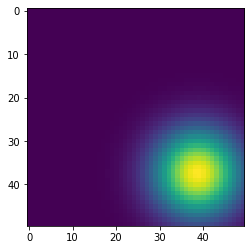

In [73]:
plt.imshow(phi1[:,:,45])

In [50]:
for mu in mus:
    print(mu)
    break

[5.13802542 2.54305269 0.50124436]


In [ ]:
def getPhi1DCompact(self,mu,coords):
        """
        Generates a (N_feat,Nt) matrix of basis vectors using features from generateFeatures 
        Arguments:
            coords: map of all (t) points in the grid
        """


        #We assume that we are using the e^-(1/2 * x^2/l^2) definition of the EQ kernel,
        #(in Mauricio's definition he doesn't use the 1/2 factor - but that's less standard).
        #c=np.sqrt(2.0)/(self.l2)
        for mus in mu:
            phi=(1/np.sqrt(2*self.sigma2*np.pi))*np.exp(-(1/(2*self.l2**2))*(2*(mus-np.array(coords))**2))
            yield phi

In [25]:
def dcost(obs,X,conc,model): # cost derivative 
    c=np.zeros(model.resolution)
    M=len(obs)
    eps=0.1
    for i,loc in enumerate(X[:,(0,2,3)]):
        c[tuple(model.getGridCoord(loc))] = 2*(conc[tuple(model.getGridCoord(loc))]-obs[i])*(1/M)
    return c

def cost(obs,X,conc,model): # cost
    c=np.zeros(model.resolution)
    M=len(obs)
    eps=0.1
    for i,loc in enumerate(X[:,(0,2,3)]):
        c[tuple(model.getGridCoord(loc))] = ((conc[tuple(model.getGridCoord(loc))]-obs[i])**2)*(1/M)
    return c

In [26]:
def computeGradientAdjoint(dcost,model):
        """
        Runs the backward PDE (adjoint problem)
        Gets called for an observation instance (H).
        (v is the result of the adjoint operation)
        """
        dt,dx,dy,dx2,dy2,Nt,Nx,Ny = model.getGridStepSize()

        v=np.zeros(((Nt,Nx,Ny)))
        v[-1,:,:]=0.0
        u=model.u
        k_0=model.k_0
        for i in range(1,Nt): #TODO might be better to rewrite as range(Nt-1,1,-1)...
    #Corner BCs   
            v[-i-1,0,0]=v[-i,0,0]+dt*(-dcost[-i,0,0]) # BC at x=0, y=0
            v[-i-1,Nx-1,Ny-1]=v[-i,Nx-1,Ny-1]+dt*(-dcost[-i,Nx-1,Ny-1]) # BC at x=xmax, y=ymax
            v[-i-1,0,Ny-1]=v[-i,0,Ny-1]+dt*( -dcost[-i,0,Ny-1]) # BC at x=0, y=ymax
            v[-i-1,Nx-1,0]=v[-i,Nx-1,0]+dt*( -dcost[-i,Nx-1,0]) # BC at x=xmax, y=0


    #Edge BCs   
            v[-i-1,Nx-1,1:Ny-1]=v[-i,Nx-1,1:Ny-1]+dt*(-dcost[-i,Nx-1,1:Ny-1] +u[1][-i,Nx-1,1:Ny-1]*(v[-i,Nx-1,2:Ny]-v[-i,Nx-1,0:Ny-2] )/(2*dy) +k_0*(v[-i,Nx-1,2:Ny]-2*v[-i,Nx-1,1:Ny-1]+v[-i,Nx-1,0:Ny-2])/dy2) # BC at x=xmax        
            v[-i-1,0,1:Ny-1]=v[-i,0,1:Ny-1]+dt*(-dcost[-i,0,1:Ny-1]+u[1][-i,0,1:Ny-1]*(v[-i,0,2:Ny]-v[-i,0,0:Ny-2] )/(2*dy) +k_0*(v[-i,0,2:Ny]-2*v[-i,0,1:Ny-1]+v[-i,0,0:Ny-2])/dy2 ) # BC at x=0

            v[-i-1,1:Nx-1,0]=v[-i,1:Nx-1,0]+dt*(   -dcost[-i,1:Nx-1,0]+u[0][-i,1:Nx-1,0]*(v[-i,2:Nx,0]-v[-i,0:Nx-2,0] )/(2*dx) +k_0*(v[-i,2:Nx,0]-2*v[-i,1:Nx-1,0]+v[-i,0:Nx-2,0])/dx2  )# BC at y=0
            v[-i-1,1:Nx-1,Ny-1]=v[-i,1:Nx-1,Ny-1]+dt*(-dcost[-i,1:Nx-1,Ny-1]+u[0][-i,1:Nx-1,Ny-1]*(v[-i,2:Nx,Ny-1]-v[-i,0:Nx-2,Ny-1] )/(2*dx)+k_0*(v[-i,2:Nx,Ny-1]-2*v[i,1:Nx-1,Ny-1]+v[-i,0:Nx-2,Ny-1])/dx2) # BC at y=ymax

    #Internal calculation (not on the boundary)
            v[-i-1,1:Nx-1,1:Ny-1]=v[-i,1:Nx-1,1:Ny-1] +dt*( -dcost[-i,1:Nx-1,1:Ny-1]+u[0][-i,1:Nx-1,1:Ny-1]*(v[-i,2:Nx,1:Ny-1]-v[-i,0:Nx-2,1:Ny-1])/(2*dx) +u[1][-i,1:Nx-1,1:Ny-1]*(v[-i,1:Nx-1,2:Ny]-v[-i,1:Nx-1,0:Ny-2] )/(2*dy)+k_0*(v[-i,2:Nx,1:Ny-1]-2*v[-i,1:Nx-1,1:Ny-1]  +v[-i,0:Nx-2,1:Ny-1])/dx2+k_0*(v[-i,1:Nx-1,2:Ny]-2*v[-i,1:Nx-1,1:Ny-1]  +v[-i,1:Nx-1,0:Ny-2])/dy2 )
        return v

In [27]:
def getPhiDerivative(self,coords):
    """
    Generates a (N_feat,Nt,Nx,Ny) matrix of basis vectors using features from generateFeatures 
    Arguments:
        coords: map of all (t,x,y) points in the grid
    """
    assert self.kernel.W is not None, "Need to call generateFeatures before computing phi."
    norm = 1./np.sqrt(self.N_feat)

    #We assume that we are using the e^-(1/2 * x^2/l^2) definition of the EQ kernel,
    #(in Mauricio's definition he doesn't use the 1/2 factor - but that's less standard).
    #c=np.sqrt(2.0)/(self.l2)
    c=1/(self.kernel.l2)
    for w,b in zip(self.kernel.W,self.kernel.b):
        phi=(c**2)*np.einsum('i,ijkl->jkl',w,coords)*norm*np.sqrt(2*self.kernel.sigma2)*np.sin(c*np.einsum('i,ijkl->jkl',w,coords)+ b)
        yield phi

In [28]:
def computeModelRegressorsDerivative(self):
        """
        Computes the regressor matrix X, using getHs from the sensor model and getPhi from the kernel.
        X here is used to infer the distribution of z (and hence the source).
        X is [features x observations]
        """
        dt,dx,dy,dx2,dy2,Nt,Nx,Ny = self.getGridStepSize()
        X = np.zeros([self.N_feat,len(self.sensormodel.obsLocs)])
        
        adjs = []
        print("Calculating Adjoints...")
        for j,H in enumerate(self.sensormodel.getHs(self)):
            print("%d/%d \r" % (j,len(self.sensormodel.obsLocs)),end="")
            adjs.append(self.computeAdjoint(H))
        print("");
        #this will run out of memory...
        print("Calculating Phis...")
        for i,phi in enumerate(getPhiDerivative(self,self.coords)):
            print("%d/%d \r" % (i,len(self.kernel.W)),end="")
            for j,adj in enumerate(adjs):
                X[i,j] = np.sum((phi*adj))*dt*dx*dy
        print("");
        #phi * v, --> scale
        self.X = X
        return X

In [29]:
def computeZDerivative(self,y):
        """
        Computes the z distribution using the regressor matrix and a vector of observations
        Arguments:
            y: a vector of observations (either generated using compute observations of given by the user in the real data case)
        """
        #uses self.X and observations y.
        dX = computeModelRegressorsDerivative(self)
        X = self.computeModelRegressors()
        SS = (1./(self.noiseSD**2))*(X@X.T) +np.eye(self.N_feat)
        SSinv= np.linalg.inv(SS)
        dZ= -(1./(self.noiseSD**2))*SSinv@((1./(self.noiseSD**2))*(dX@X.T + X@dX.T))@(SSinv @self.X@y)+(1./(self.noiseSD**2))*SSinv@dX@y
        
         #sum_cc.flatten())
        return dZ

In [30]:
def computeSourceDerivative(model,z,y,coords=None):
        """
        uses getPhi from the kernel and a given z vector to generate a source function     
        set coords to a matrix: (3 x Grid Resolution), e.g. (3, 300, 80, 80)
                e.g. coords=np.asarray(np.meshgrid(tt,xx,yy,indexing='ij'))
        
        """
        if coords is None: coords = model.coords
        resolution = np.array(coords.shape[1:])
        dsource = np.zeros(resolution) 
        dZ = computeZDerivative(model,y)
        for i, (phi,dphi) in enumerate(zip(model.kernel.getPhi(model.coords),getPhiDerivative(model,model.coords))):
            dsource += dphi*z[i] + phi*dZ[i]
        
        return dsource

In [31]:
def d_mLLambda(l,model,yTrain,yTest,tTrain,tTest):
    
    # change parameters in model object
    
    model.sensormodel=sensors
    
    model.kernel.l2=l 
    
    model.computeModelRegressors() # Compute regressor matrix 
    meanZ, covZ = model.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    source= model.computeSourceFromPhi(meanZ)
    # calculate useful values
    dt,dx,dy,dx2,dy2,Nt,Nx,Ny = model.getGridStepSize()
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    
    model.sensormodel=sensorsTest
    #compute cost derivative and cost
    dc=dcost(yTest,tTest,conc,model)
    c=cost(yTest,tTest,conc,model)
    
    # derivative of h operator with respect to parameters
    model.sensormodel=sensors
    dmH=computeSourceDerivative(model,meanZ,yTrain)

    # compute and calculate Lagrangian derivative integral
    integrand = -computeGradientAdjoint(dc,model)*dmH
    #L_m = np.trapz(integrand,dx=dt)
    #model.sensormodel=sensors
    L_m = np.sum(integrand)*dt*dx*dy #alternate calculation using naive numerical integration
    return L_m, dc,c

In [32]:
reps=10

# initialise outputs
p=np.zeros((1,reps)) # parameters
p2=np.zeros((1,reps)) # parameters
d=np.zeros((1,reps-1)) # derivative
dTest=np.zeros((1,reps-1)) # forward difference derivative approximation
dTest2=np.zeros((1,reps-1)) # central difference derivative approximation
Fc=np.zeros((1,reps-1)) # integrated cost function
p[:,0]=1 # first parameter value]
p2[:,0]=1 # first parameter value
eps2=1e-6
for i in range(reps-1):
    l = p[:,i]
    l2 = p2[:,i]
    dmL, dc,c=d_mLLambda(l,mInfer,yTrain,yTest,X,X2)
    d[:,i]=dmL
    p[:,i+1]=p[:,i]-1*dmL
    
    Fc[:,i] = np.sum(c)*dt*dx*dy
    #dmL2, dc2,c2=d_mLLambda(l2+eps2,mInfer,yTrain,tlocL)
    #dmL3, dc3,c3=d_mLLambda(l2,mInfer,yTrain,tlocL)
    dmL4, dc4,c4=d_mLLambda(l+eps2,mInfer,yTrain,yTest,X,X2)
    #dmL3, dc3,c3=d_mL(k_01,u1,eta1+eps2,mInfer,yTrain,tlocL,sourceInfer)
    #dmL4, dc4,c4=d_mL(k_01+eps2,u1,eta1,mInfer,yTrain,tlocL,sourceInfer)
    # dmL5, dc5,c5=d_mL(dmH,k_01,u1-eps2,eta1,m,yTrain,tlocL,sourceInfer)
    #dmL6, dc6,c6=d_mL(dmH,k_01,u1,eta1-eps2,m,yTrain,tlocL,sourceInfer)
    # dmL7, dc7,c7=d_mL(dmH,k_01-eps2,u1,eta1,m,yTrain,tlocL,sourceInfer)
    
    #dTest[:,i:i+1] = (np.array((sum((c2))*dt-sum((c5))*dt,sum((c3))*dt-sum((c6))*dt,sum((c4))*dt-sum((c7))*dt)))/(2*eps2)
    #dTest2[:,i:i+1] = ((sum(c2)*dt)-(sum(c3)*dt))/(eps2)
    dTest[:,i:i+1] = ((np.sum(c4)*dt*dx*dy)-(np.sum(c)*dt*dx*dy))/(eps2)
    p2[:,i+1]=p2[:,i]-1*dTest[:,i:i+1] 

Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calcula

In [33]:
d

array([[ 0.05997088, -0.04357205, -0.00363412,  0.0131134 , -0.04248216,
         0.05833388, -0.0651614 ,  0.04168904, -0.01207453]])

In [34]:
dTest

array([[ 0.05696454, -0.0310138 , -0.00396983,  0.0119966 , -0.04023705,
         0.05410948, -0.05688392,  0.03765681, -0.0119909 ]])

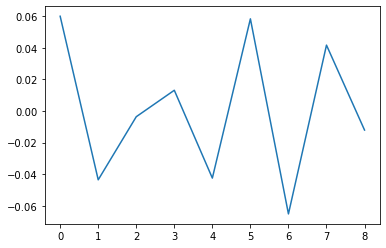

In [35]:
plt.plot(d.T)

In [36]:
def FullCost(x,model,yTrain,yTest,tTrain,tTest):
    model.sensormodel=sensors
    model.kernel.l2=x
    dt,dx,dy,dx2,dy2,Nt,Nx,Ny = model.getGridStepSize()
    model.computeModelRegressors() # Compute regressor matrix 
    meanZ, covZ = model.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    source= model.computeSourceFromPhi(meanZ)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    model.sensormodel=sensorsTest
    #compute cost derivative and cost
    dc=dcost(yTest,tTest,conc,model)
    c1=cost(yTest,tTest,conc,model)
    
    c = np.sum(c1)*dt*dx*dy
    
    return c

In [37]:
def FullDeriv(x,model,yTrain,yTest,tTrain,tTest):
    model.sensormodel=sensors
    model.kernel.l2=x 

    
    # calculate useful valyes
    dt,dx,dy,dx2,dy2,Nt,Nx,Ny = model.getGridStepSize()
    model.computeModelRegressors() # Compute regressor matrix 
    meanZ, covZ = model.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    source= model.computeSourceFromPhi(meanZ)
    # compute concentration with new parameters
    conc=model.computeConcentration(source)
    model.sensormodel=sensorsTest
    #compute cost derivative and cost
    dc=dcost(yTest,tTest,conc,model)
    c=cost(yTest,tTest,conc,model)
    
    # derivative of h operator with respect to parameters
    model.sensormodel=sensors
    dmH=computeSourceDerivative(model,meanZ,yTrain)

    # compute and calculate Lagrangian derivative integral
    integrand = -computeGradientAdjoint(dc,model)*dmH
    #L_m = np.trapz(integrand,dx=dt)
    L_m = np.sum(integrand)*dt*dx*dy
    return L_m

In [38]:
fc = np.zeros(100)
dc = np.zeros(100)
x=np.linspace(1,5,100)
for i in range(100):
    
    fc[i] = FullCost(x[i],mInfer,yTrain,yTest,X,X2)
    dc[i] = FullDeriv(x[i],mInfer,yTrain,yTest,X,X2)

Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calcula

249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 


249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 
Calculating Adjoints...
249/250 
Calculating Phis...
1999/2000 


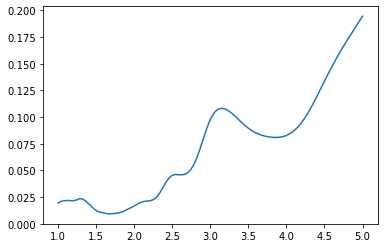

In [39]:
plt.plot(x,fc)

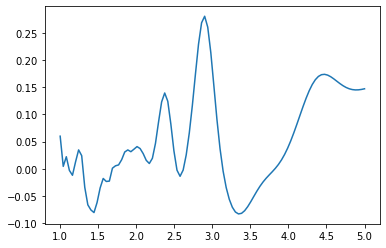

In [40]:
plt.plot(x,dc)